# Pose Detection and Matching with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses and similarity matching between those poses.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kasidit0052/MatchingOpenpose/blob/main/OpenPose.ipynb)

## Install OpenPose

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os.path
import numpy as np
from tqdm.notebook import tqdm
import pathlib
from glob import glob
import os
from os.path import exists, join, basename, splitext

In [3]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`
!mkdir openpose/images openpose/videos 

Selecting previously unselected package libgflags2.2.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

# Openpose Python API and Pose Matching Algorithm

### **Upload Images** 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def test():
  folder_path = "drive/MyDrive/ProjetS8/data/256/full_body/1"
  image_path = folder_path+"/body.jpg"
  image = cv2.imread(image_path)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
  #cv2.imwrite(folder_path+"/test.jpg",image)

### **Pose Estimation on single Image**

In [5]:
# Import general libraries
import sys
import cv2
import warnings
from google.colab.patches import cv2_imshow
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set Python Openpose Directory for python api (Important)
# pyopenpose_dir = os.path.join(OpenposeDir,'build','python') # ex: '/content/openpose/build/python'
pyopenpose_dir = "openpose/build/python"
if pyopenpose_dir not in sys.path:
    sys.path.append(pyopenpose_dir)
from openpose import pyopenpose as op

# Custom Params (refer to openpose/include/openpose/flags.hpp for more parameters)
params = dict()
#params["model_folder"] = os.path.join(OpenposeDir,'models')  # ex: '/content/openpose/models'
params["model_folder"] = "openpose/models"
# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

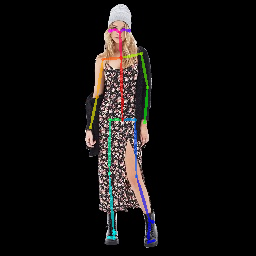

In [6]:
# Process Image
datum = op.Datum()
folder_path = "drive/MyDrive/ProjetS8/data/256/full_body/1"
image_path = folder_path+"/body.jpg"
input_image = cv2.imread(image_path) # Change Image Here
datum.cvInputData = input_image
opWrapper.emplaceAndPop(op.VectorDatum([datum]))
network_output = datum.poseKeypoints

# Display Image
cv2_imshow(datum.cvOutputData)

### **Unwrapping Person Keypoints from network output**

In [7]:
# Import general libraries
import copy
import pandas as pd
from itertools import zip_longest
import json

# Function for grouping list items 
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    args = [iter(iterable)] * n
    return list(zip_longest(*args, fillvalue=fillvalue))

def get_keypoints(network_output):
  # Get body parts and pose pairs from openpose library (refer to openpose/src/openpose/pose/poseParameters.cpp for more parameters)
  BODY_PARTS = op.getPoseBodyPartMapping(op.BODY_25)
  POSE_PAIRS = op.getPosePartPairs(op.BODY_25)
  POSE_PAIRS = grouper(POSE_PAIRS, 2, None)

  # Unwrapping Person Keypoints from Openpose Network Output
  keypoints = []
  index_names = copy.deepcopy(BODY_PARTS)
  index_names.pop(25)
  for human in network_output:
      output_sub_arr = {}
      for i in range(len(human)):
          output_sub_arr[BODY_PARTS[i]]= [int(human[i][0]),int(human[i][1])]
      #print("\n   Person Detected")
      #print (pd.DataFrame(output_sub_arr.values(), columns=['x','y'], index=list(index_names.values())))
      keypoints.append(output_sub_arr) 

  # Cover Keypoints to Keypoints_list to use in further processing
  poses_list = []
  for pose in keypoints:
      pose = list(pose.values())
      pose = [(None,None) if x==[0,0] else tuple(x) for x in pose]
      poses_list.append(pose)
  return keypoints, poses_list

### **Recheck prediction By Drawing Pose Pairs through OpenCV**

In [8]:
def draw_line(pose,path,format):
  black_image = np.zeros((format,format,3), np.uint8)
  imageToRecheck = black_image
  # Draw human poses on image
  POSE_PAIRS = op.getPosePartPairs(op.BODY_25)
  POSE_PAIRS = grouper(POSE_PAIRS, 2, None)
  for pair in POSE_PAIRS:
      idFrom = pair[0]
      idTo = pair[1]
      if all(pose[idFrom]) and all(pose[idTo]):
          cv2.line(imageToRecheck, pose[idFrom], pose[idTo], (255, 255, 255), 3)
  # Visualize Image
  #cv2_imshow(imageToRecheck)
  # save 
  cv2.imwrite(path,imageToRecheck)

In [9]:
def draw_point(pose,path,format):
  black_image = np.zeros((format,format,3), np.uint8)
  imageToRecheck = black_image
  # Draw human poses on image
  for p in pose:
      if all(p):
        cv2.circle(imageToRecheck,p, radius=2, color=(255, 255, 255), thickness=-1)
  # Visualize Image
  #cv2_imshow(imageToRecheck)
  # save 
  cv2.imwrite(path,imageToRecheck)

In [10]:
# Pipeline 

def main(image_folder_path,size):
  # Init 
  folder_path_to_remove = []
  # Custom Params (refer to openpose/include/openpose/flags.hpp for more parameters)
  params = dict()
  #params["model_folder"] = os.path.join(OpenposeDir,'models')  # ex: '/content/openpose/models'
  params["model_folder"] = "openpose/models"
  # Starting OpenPose
  opWrapper = op.WrapperPython()
  opWrapper.configure(params)
  opWrapper.start()

  # Process Image
  datum = op.Datum()
  folder_paths = glob(image_folder_path, recursive = True)
  for folder_path in tqdm(folder_paths):
    image_path = folder_path+"/body.jpg"
    input_image = cv2.imread(image_path) # Change Image Here
    datum.cvInputData = input_image
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))
    network_output = datum.poseKeypoints
    if network_output is None :
      print(folder_path)
      folder_path_to_remove.append(folder_path)
    else:
      keypoints, poses_list = get_keypoints(network_output)
      with open(folder_path+"/keypoints.json", "w") as fp:
        json.dump(keypoints[0], fp,  indent=4)
      draw_line(poses_list[0],folder_path+"/line.jpg",size)
      draw_point(poses_list[0],folder_path+"/point.jpg",size)
  print(folder_path_to_remove)

main("drive/MyDrive/ProjetS8/data/256/upper_body/*",size=256)
#main("drive/MyDrive/ProjetS8/data/512/upper_body/*",size=512)

  0%|          | 0/5905 [00:00<?, ?it/s]

[]


## **Pose Matching**

### **Compare Similarity Between two pose**

In [ ]:
# Import Mathematical Libraries
import math
import numpy as np
import pandas as pd
from scipy import spatial

def similarity_score(pose1, pose2):
    p1 = []
    p2 = []

    # Remove keypoints when keypoint values is none
    pose1_df = pd.DataFrame(pose1, columns=['Xp1','Yp1'])
    pose2_df = pd.DataFrame(pose2, columns=['Xp2','Yp2'])
    pose_df = pd.concat([pose1_df, pose2_df],axis = 1).dropna().reset_index(drop=True)
    pose1_df = pose_df[['Xp1','Yp1']]
    pose2_df = pose_df[['Xp2','Yp2']]

    pose1 = pose1_df.to_numpy()
    pose2 = pose2_df.to_numpy()

    pose_1 = np.array(pose1, dtype=np.float)
    pose_2 = np.array(pose2, dtype=np.float)

    # Normalize coordinates
    pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
    pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
    pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
    pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

    # Turn (16x2) into (32x1)
    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]

        p1.append(x1)
        p1.append(y1)
        p2.append(x2)
        p2.append(y2)

    p1 = np.array(p1)
    p2 = np.array(p2)

    # Looking to minimize the distance if there is a match
    # Computing two different distance metrics
    cosineDistance = spatial.distance.cosine(p1, p2)
    euclideanDistance = math.sqrt(2 * cosineDistance)

    # Print Score as a output
    print("Cosine Distance:", cosineDistance)
    print("Euclidean Distance:",euclideanDistance)

In [ ]:
similarity_score(poses_list[0], poses_list[1])

### **Visualizing Similarity Output**

In [ ]:
# Import visualization library
import matplotlib.pyplot as plt

def visualize_output(pose1, pose2, size):
    
    # Initialize blank canvas
    canvas = np.ones(size)

    # Plot points on images
    for pair in POSE_PAIRS:
        idFrom = pair[0]
        idTo   = pair[1]
        if all(pose1[idFrom]) and all(pose1[idTo]):
            cv2.line(canvas, pose1[idFrom], pose1[idTo], (0, 0, 255), 3)
    for pair in POSE_PAIRS:
        idFrom = pair[0]
        idTo   = pair[1]
        if all(pose2[idFrom]) and all(pose2[idTo]):
            cv2.line(canvas, pose2[idFrom], pose2[idTo], (255, 0, 0), 3)

    # Visualize images
    fig3 = plt.figure(figsize = (10,10))
    plt.imshow(canvas[:,:,::-1])
    plt.grid(True)

In [ ]:
visualize_output(poses_list[0], poses_list[1], input_image.shape)

### **Applying Cropping and scaling to improve cosine similarity**

In [ ]:
# Extract poses list
pose1 = poses_list[0]
pose2 = poses_list[1]

# Corvert list to DataFrame(to handle null value)
pose1_df = pd.DataFrame(pose1, columns=['Xp1','Yp1'])
pose2_df = pd.DataFrame(pose2, columns=['Xp2','Yp2'])
pose_df = pd.concat([pose1_df, pose2_df],axis = 1)

# Cropping Pose
pose_df['Xp1'] = pose_df['Xp1'] - pose_df['Xp1'].min()
pose_df['Yp1'] = pose_df['Yp1'] - pose_df['Yp1'].min()
pose_df['Xp2'] = pose_df['Xp2'] - pose_df['Xp2'].min()
pose_df['Yp2'] = pose_df['Yp2'] - pose_df['Yp2'].min()

# Resizing Pose
resize_x = pose_df['Xp2'].max()/pose_df['Xp1'].max()
resize_y = pose_df['Yp2'].max()/pose_df['Yp1'].max()

pose_df['Xp1'] = pose_df['Xp1']*resize_x
pose_df['Yp1'] = pose_df['Yp1']*resize_y

# Get dimensions of output window
max_y = max(pose_df['Yp1'].max(), pose_df['Yp2'].max())
max_x = max(pose_df['Xp1'].max(), pose_df['Xp2'].max())
dim = (int(max_y), int(max_x), 3)

# Convert DataFrame back to Pose lists
pose1_df = pose_df[['Xp1','Yp1']]
pose2_df = pose_df[['Xp2','Yp2']]
pose1_new = [ tuple(map(int, x)) if not np.isnan(x).all()  else (None,None) for x in pose1_df.values.tolist()]
pose2_new = [ tuple(map(int, x)) if not np.isnan(x).all()  else (None,None) for x in pose2_df.values.tolist()]

# Visualize and Calculate similarity score again
visualize_output(pose1_new, pose2_new, dim)
similarity_score (pose1_new, pose2_new)

### **Applying Affine Transformation to improve cosine similarity**

In [ ]:
reference_pose = pose1_new
relative_pose  = pose2_new
modified_pose  = []

# Function to get Affine Transformation matrix
def AffineTransform(pose1,pose2):
    q = np.array([[pose1[1][0]],[pose1[1][1]],[pose1[8][0]],[pose1[8][1]]], np.float)

    p = np.array([[pose2[1][0], pose2[1][1], 1.0, 0.0, 0.0, 0.0], \
                  [0.0, 0.0, 0.0, pose2[1][0], pose2[1][1], 1.0], \
                  [pose2[8][0], pose2[8][1], 1.0, 0.0, 0.0, 0.0], \
                  [0.0, 0.0, 0.0, pose2[8][0], pose2[8][1], 1.0]], np.float)

    A, res, rank, s = np.linalg.lstsq(p, q)

    T = np.array([[A[0], A[1], A[2]],[A[3], A[4], A[5]],[0.0, 0.0, 1.0]], np.float)

    return T

# Apply transformation on relative pose
for k in range (0,len(relative_pose)):
        if all(relative_pose[k]):
          i = relative_pose[k][0]
          j = relative_pose[k][1]
          T = AffineTransform(reference_pose,relative_pose)
          cur_pt = np.array([i,j,1])
          transformed_pt = T.dot(cur_pt)
          
          transformed_pt = transformed_pt / transformed_pt[2]
          modified_pose.append((int(transformed_pt[0]), int(transformed_pt[1])))
        else:
          modified_pose.append((None,None))

# Visualize and Calculate similarity score again
visualize_output(reference_pose, modified_pose, dim)
similarity_score(reference_pose, modified_pose)